<a href="https://colab.research.google.com/github/hirurana/tennis_sim/blob/main/tennis_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - Tennis Match Simulator

In [1]:
#game state updater
def update_game_state(winner, g_st):
    # init vars
    loser = abs(winner-1)
    ad_out = False
        
    # is deuce?
    if (g_st[winner] == g_st[loser] and g_st[winner] == 3) or (max(g_st) == 4 and min(g_st) == 3):
        # if other side is winning sub their score and do not increment
        if g_st[winner] < g_st[loser]:
            ad_out = True
    
    # increment point
    if not ad_out:
        g_st[winner] += 1 
    else:
        g_st[loser] -= 1 #leader loses advantage
    return g_st

In [2]:
# set state updater
def update_set_state(winner, s_st): 
    #use each point to update the current game state
    current_game_num = list(s_st.keys())[-1]
    g_st = s_st[current_game_num]

    # simulate the point won in current game
    g_st = update_game_state(winner, g_st)

    #if game has been won start new game
    loser = abs(winner-1)
    if (g_st[winner] >= 4 and g_st[loser] < 3) or g_st[winner] == 5:        
        #start new game
        new_game_num = 'game'+str(len(s_st)+1)
        s_st[new_game_num] = [0,0]
        g_st = s_st[new_game_num]
    return s_st, g_st

In [3]:
# match state updater
def update_match_state(winner, m_st, config):
    '''
        TODO:
        #deal with tie-breaks and advantage sets in final set
        #determine if match has been won
        #allow configuration to other formats
    '''
    
    # get first set
    current_set_num = list(m_st.keys())[-1]
    s_st = m_st[current_set_num]
    
    loser = abs(winner-1)
    
    #simulate a single point in a game in a set
    s_st, cg_score = update_set_state(winner, s_st)
    
    #calculate set score
    game_scores = [g.index(max(g)) for g in list(s_st.values()) if max(g) >= 4] #only check compeleted matches
    w_wins = game_scores.count(winner)
    l_wins = game_scores.count(loser)

    set_scores = [0,0]
    set_scores[winner] = w_wins
    set_scores[loser] = l_wins

    #determine if the set has been won and start new set
    if len(s_st) > 6:
        if (w_wins-l_wins) >=2:
            #TODO: fix the appearing game
            del s_st[list(s_st.keys())[-1]]
            #start new set
            new_set_num = 'set'+str(len(m_st)+1)
            m_st[new_set_num] = {'game1': [0,0]}
            s_st = m_st[new_set_num]
    return m_st, set_scores, cg_score

Check if the current leader is about to play for a critical point

In [4]:
#Critical Point checker
def critical_point_check(current_scores, p0_prob, nf):
    '''
        Reduces probability of player winning if is a critical point
    '''
    #parse current_states
    cg_score, cs_scores, m_score = current_scores
    nerv_prob = p0_prob
    
    #check if game point
    game_points = [set([0,3]),set([1,3]),set([2,3]), set([5,3])]
    
    #TODO: if player is serving for game reduce p
    
    
    #  if critical point reduce prob of winning
    if set(cg_score) in game_points:
        # reduce p
        nerv_prob*=(1-nf)
        #check if set point
        if min(cs_scores) >= 4 and max(cs_scores)-min(cs_scores) == 1:
            #reduce p again
            nerv_prob*=(1-nf)
            #check if match point
            if max(m_score)-min(m_score) == 1:
                # reduce p again
                nerv_prob*=(1-nf)

    return None if p0_prob == nerv_prob else [nerv_prob,1-nerv_prob]

Function to play a single match

In [5]:
import numpy as np
# Simulate match from list of inputs
def play_match(p0_prob, nf):
    '''
        TODO: 
        Allow configurability of how match can be won
    '''
    # init vars and state
    p1_prob = 1-p0_prob
    winner = -1
    match_st = {'set1': {'game1': [0, 0]}}
    cg_score = cs_scores = m_score = [0,0]
    nerve_factor = nf
#     serving = np.random.randint(0,1) #sim coin toss at start of match
    
    # run until match won
    while True:
        #critical pointer checker
        critical_probs = critical_point_check([cg_score, cs_scores, m_score], p0_prob, nerve_factor)
        point_probs = [p0_prob,p1_prob] if not critical_probs else critical_probs
        
        # generate stream of inputs
        point = np.random.choice([0,1], p=point_probs)
        # update match state, returns current match, set and game state
        match_st, cs_scores, cg_score = update_match_state(point, match_st, None)
        
        # check if game won
        if len(match_st) > 2:
            # calc set scores
            game_scores = [[g.index(max(g)) for g in list(s.values())] for s in list(match_st.values())[:-1]]
            set_scores = [1 if s.count(1) > s.count(0) else 0 for s in game_scores]
            w_wins = set_scores.count(point)
            l_wins = set_scores.count(abs(point-1))
            
            m_score[point] = w_wins
            m_score[abs(point-1)] = l_wins
            
            # check if match won, break loop (best of three)
            if (w_wins-l_wins) >=2 or len(match_st) == 3:
                #remove new extra set
                del match_st[list(match_st.keys())[-1]]
                winner = point
                break
            # players have tied, play one more set
    
    return match_st, winner

Simulate a number of matches

In [6]:
def simulate_matches(p0_prob, nf, num_matches):
    #init vars for hists
    results = num_sets_played = num_games_played = all_game_outcomes = np.array([])

    for i in range(0,num_matches):
        #get the result of playing a single match
        match_result, winner = play_match(p0_prob, nf)
        results = np.append(results,winner)

        #get all game outcomes from the match
        game_outcomes = np.array([[g.index(max(g)) for g in list(s.values())] for s in list(match_result.values())[:-1]]).flatten()
        all_game_outcomes = np.concatenate((all_game_outcomes, game_outcomes), axis=None)
        
        #get number of sets played in the match
        num_sets_played = np.append(num_sets_played,len(match_result))
        
        #get number of games played in the match
        num_games_played = np.concatenate((num_games_played,[len(s) for s in list(match_result.values())]), axis=None)
    
    return results, num_sets_played, num_games_played, all_game_outcomes

# 2 - Histograms

In [7]:
#run simulation
results, num_sets_played, num_games_played, all_game_outcomes = simulate_matches(0.5, 0.5, 1000)

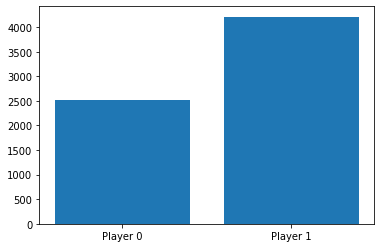

Player 0 won 2526/6737 games (37.49443372420959%)
Player 1 won 4211/6737 games (62.505566275790414%)


In [8]:
#Game Outcomes
import matplotlib.pyplot as plt

_, game_counts = np.unique(all_game_outcomes, return_counts=True)
plt.bar(['Player 0', 'Player 1'], game_counts)
plt.show()
print(f"Player 0 won {game_counts[0]}/{len(all_game_outcomes)} games ({game_counts[0]/len(all_game_outcomes)*100}%)\nPlayer 1 won {game_counts[1]}/{len(all_game_outcomes)} games ({game_counts[1]/len(all_game_outcomes)*100}%)")

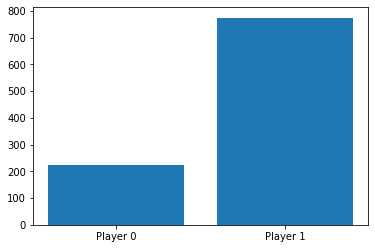

Player 0 won 225/1000 matches (22.5%)
Player 1 won 775/1000 matches (77.5%)


In [9]:
#Match Outcomes
import matplotlib.pyplot as plt

_, match_counts = np.unique(results, return_counts=True)
plt.bar(['Player 0', 'Player 1'], match_counts)
plt.show()
print(f"Player 0 won {match_counts[0]}/{len(results)} matches ({match_counts[0]/len(results)*100}%)\nPlayer 1 won {match_counts[1]}/{len(results)} matches ({match_counts[1]/len(results)*100}%)")

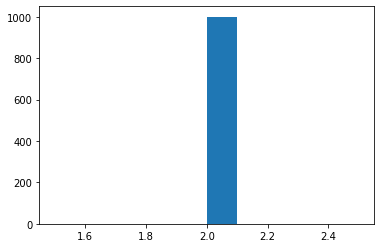

In [10]:
#histogram of number of sets played
plt.hist(num_sets_played)
plt.show()

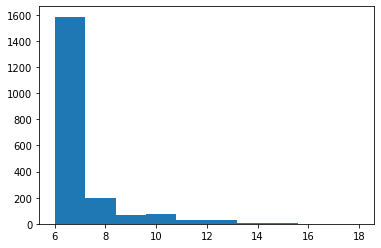

In [11]:
#histogram of number of games played per set
plt.hist(num_games_played)
plt.show()

# 3 - Varying Probability of Player 0

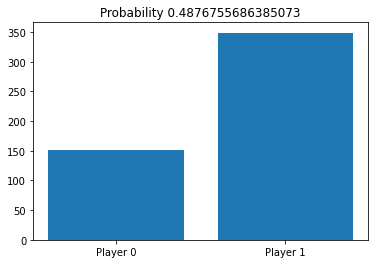

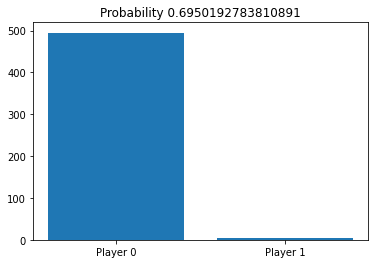

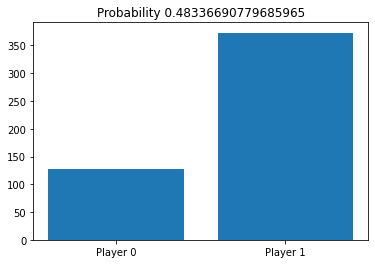

In [13]:
import random

for i in range(0,3):
    p = random.uniform(0.3,0.7)
    results, num_sets_played, num_games_played, all_game_outcomes = simulate_matches(p, 0.2, 500)
    plt.figure()
    plt.title('Probability '+str(p))
    _, match_counts = np.unique(results, return_counts=True)
    plt.bar(['Player 0', 'Player 1'], match_counts)
plt.show()